In [1]:
import sim
%pylab inline
plt.style.use('dark_background')
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['animation.embed_limit'] = 2**128

Populating the interactive namespace from numpy and matplotlib


In [2]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Pioneer_p3dx'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Pioneer is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Failed connecting to remote API server


In [3]:
# Force Field
def force_goal(x, y, goal):
    goal_x, goal_y, k_goal = goal
    Fx_goal, Fy_goal = k_goal * (goal_x - x), k_goal *(goal_y - y)
    return Fx_goal, Fy_goal

def force_obstacle(x, y, obstacle):
    (obs_x, obs_y, k_obs) = obstacle
    dist_x, dist_y = x - obs_x, y - obs_y
    dist_obs = np.hypot(dist_x, dist_y)
    Fx_obs = (dist_x / dist_obs) * k_obs / dist_obs ** 3
    Fy_obs = (dist_y / dist_obs) * k_obs / dist_obs ** 3

    return Fx_obs, Fy_obs 

def total_force(x, y, goal, obstacles):
    Fx, Fy = force_goal(x, y, goal)

    for obs in obstacles:
        Fo_x, Fo_y = force_obstacle(x, y, obs)
        Fx += Fo_x
        Fy += Fo_y
    return Fx, Fy

# Potential Field
def p_goal(x, y, goal):
    goal_x, goal_y, k_goal = goal
    Fx_goal, Fy_goal = k_goal * (goal_x - x), k_goal *(goal_y - y)
    return np.sqrt(Fx_goal**2 + Fy_goal**2)

def p_obstacle(x, y, obstacle):
    (obs_x, obs_y, k_obs) = obstacle
    k_obs = k_obs / 2
    dist_x, dist_y = x - obs_x, y - obs_y
    dist_obs = np.hypot(dist_x, dist_y)
    Fx_obs = (dist_x / dist_obs) * k_obs / dist_obs ** 3
    Fy_obs = (dist_y / dist_obs) * k_obs / dist_obs ** 3
    return np.sqrt(Fx_obs**2 + Fy_obs**2)

def total_p(x, y, goal, obstacles):
    P = p_goal(x, y, goal)
    for obs in obstacles:
        Po = p_obstacle(x, y, obs)
        P += Po
    return P

In [4]:
def plot_vector_field(ax=plt, fmax = .8):
    X, Y = np.meshgrid(np.arange(-10, 10, .5), np.arange(-10, 10, .5))

    # Vector field of the forces
    Fx, Fy = total_force(X, Y, goal, obstacles)
    P = total_p(X, Y, goal, obstacles)

    # For visualization
    F_m = np.hypot(Fx, Fy)
    Fx[F_m > fmax], Fy[F_m > fmax] = None, None
    
    # Plot
    # quiver(X, Y, Fx, Fy,  F_m, color='0.4', scale=None)
    ax.quiver(X, Y, Fx, Fy, color='0.4')
    return X, Y, Fx, Fy, P

def simulate(q, goal, p):
    # map 'q' and 'goal' to indices in 'p'
    q = [int((q[0]+10)*2), int((q[1]+10)*2)]
    goal = [int((goal[0]+10)*2), int((goal[1]+10)*2)]
    
    trajectory = []
    while q != goal and len(trajectory) < 200:
        # add the current position to traj
        trajectory.append(np.array((q[0]/2.-10., q[1]/2.-10.)))
        
        # find the one with lowest potential among all reachable cells
        lowest = q
        if (q[0]-1 >= 0 and q[1]-1 >= 0) and (p[q[1]-1, q[0]-1] < p[lowest[1], lowest[0]]):
            lowest = [q[0]-1, q[1]-1]
        if (q[0]-1 >= 0) and (p[q[1], q[0]-1] < p[lowest[1], lowest[0]]):
            lowest = [q[0]-1, q[1]]
        if (q[0]-1 >= 0 and q[1]+1 <= 39) and (p[q[1]+1, q[0]-1] < p[lowest[1], lowest[0]]):
            lowest = [q[0]-1, q[1]+1]
        if (q[1]-1 >= 0) and (p[q[1]-1, q[0]] < p[lowest[1], lowest[0]]):
            lowest = [q[0], q[1]-1]
        if (q[1]+1 <= 39) and (p[q[1]+1, q[0]] < p[lowest[1], lowest[0]]):
            lowest = [q[0], q[1]+1]
        if (q[0]+1 <= 39 and q[1]-1 >= 0) and (p[q[1]-1, q[0]+1] < p[lowest[1], lowest[0]]):
            lowest = [q[0]+1, q[1]-1]
        if (q[0]+1 <= 39) and (p[q[1], q[0]+1] < p[lowest[1], lowest[0]]):
            lowest = [q[0]+1, q[1]]
        if (q[0]+1 <= 39 and q[1]+1 <= 39) and (p[q[1]+1, q[0]+1] < p[lowest[1], lowest[0]]):
            lowest = [q[0]+1, q[1]+1]
        # If all cells around q have higher potential, then q is a local minima
        if (lowest == q):
            # label the local minima as occupied
            p[q[1],q[0]] += 20
            '''
            if (q[1]-1 >= 0):
                if (q[0]-1 >= 0):
                    p[q[1]-1, q[0]-1] += 3
                p[q[1]-1, q[0]] += 5
                if (q[0]+1 <= 39):
                    p[q[1]-1, q[0]+1] += 3
            if (q[0]-1 >= 0):
                p[q[1], q[0]-1] += 5
            if (q[0]+1 <= 39):
                p[q[1], q[0]+1] += 5
            if (q[1]+1 <= 39):
                if (q[0]-1 >= 0):
                    p[q[1]+1, q[0]-1] += 3
                p[q[1]+1, q[0]] += 5
                if (q[0]+1 <= 39):
                    p[q[1]+1, q[0]+1] += 3
            '''
            index = len(trajectory)-1
            trajectory.pop(index)
            index -= 1
            # move backward along the traj until we get out of the trap
            while index >= 0 and (p[q[1], q[0]] > p[int(trajectory[index][1]*2+20), int(trajectory[index][0]*2+20)]):
                q = [int(trajectory[index][0]*2+20), int(trajectory[index][1]*2+20)]
                trajectory.pop(index)
                index -= 1
            continue
        q = lowest

    for i in range(0,5):
        trajectory.append(np.array((q[0]/2.-10., q[1]/2.-10.)))
    return np.array(trajectory)

<ipython-input-3-d377a82ec86a>:11: RuntimeWarning: invalid value encountered in true_divide
  Fx_obs = (dist_x / dist_obs) * k_obs / dist_obs ** 3
<ipython-input-3-d377a82ec86a>:12: RuntimeWarning: invalid value encountered in true_divide
  Fy_obs = (dist_y / dist_obs) * k_obs / dist_obs ** 3
<ipython-input-3-d377a82ec86a>:36: RuntimeWarning: invalid value encountered in true_divide
  Fx_obs = (dist_x / dist_obs) * k_obs / dist_obs ** 3
<ipython-input-3-d377a82ec86a>:37: RuntimeWarning: invalid value encountered in true_divide
  Fy_obs = (dist_y / dist_obs) * k_obs / dist_obs ** 3
<ipython-input-4-70c447b3d41b>:10: RuntimeWarning: invalid value encountered in greater
  Fx[F_m > fmax], Fy[F_m > fmax] = None, None


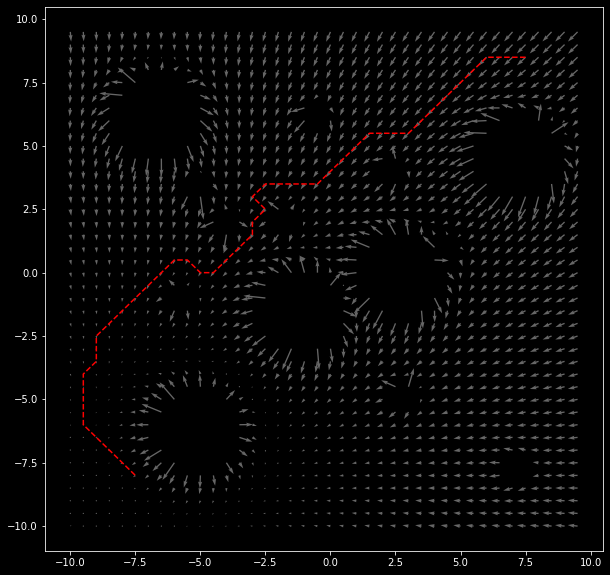

In [5]:
# Goal
goal = [-7.5, -8., 0.02]

# Obstacles (x, y, k), where k is the rejection multiplier
cuboid_k = np.sqrt(4**2+1**2)/2+0.5
cylinder_k = 1/2-0.45
obstacles = [[2.725, 0, cuboid_k],
             [7.425, 4.725, cuboid_k],
             [-1.025, -1.5, cuboid_k],
             [-6.7, 6.4, cuboid_k],
             [-5.15, -6.2, cuboid_k],
             [-1.775, 2.1, cylinder_k],
             [-5.8, -0.975, cylinder_k],
             [7.275, -7.75, cylinder_k],
             [2.425, 4.075, cylinder_k],
             [4.4, 0.875, cylinder_k],
             [2.825, -4.85, cylinder_k],
             [-0.525, 6.3, cylinder_k],
             [-5.125, 3.425, cylinder_k],
             [-4,2,cylinder_k]
              ]

#obstacles = []


# Initial location of the robot
q = np.array((7.5, 8.5))

X, Y, _, _, P = plot_vector_field()
trajectory = simulate(q, goal, P)
plot(trajectory[:,0], trajectory[:,1], 'r--')

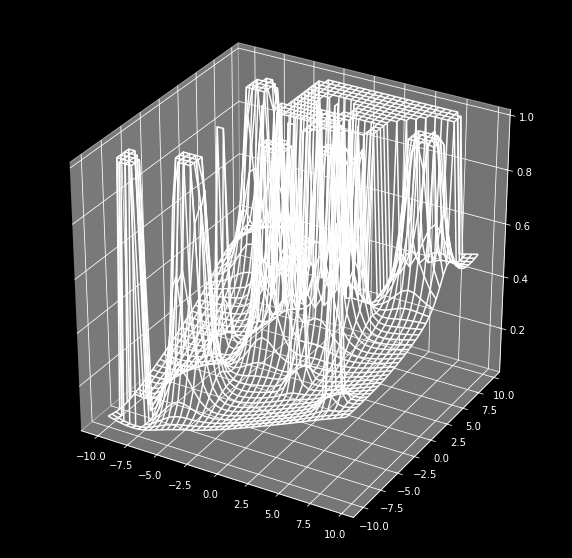

In [6]:
# Plot a 3D graph to show the potential field
from mpl_toolkits.mplot3d import axes3d

m, n = P.shape
for i in range(m):
    for j in range(n):
        if P[i, j] > 1:
            P[i, j] = 1

ax = axes(projection = '3d')
ax.plot_wireframe(X, Y, Z=P)

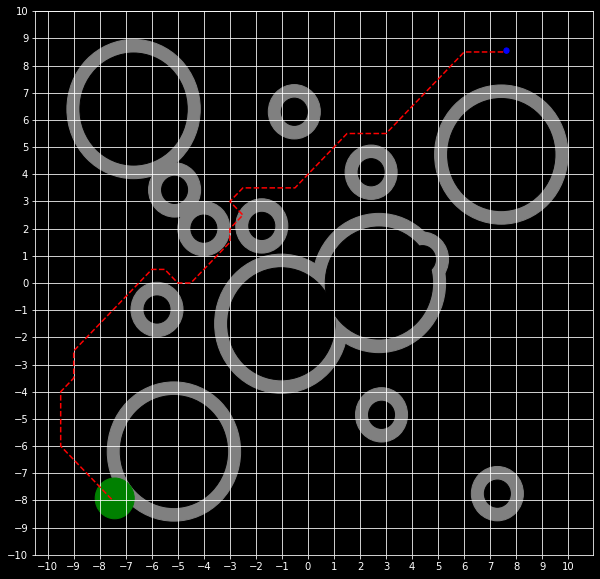

In [7]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
# Obstacles
# Obstacles
def plot_cir(r):
    axis = gca()
    axis.add_patch(Circle(
        r[0],
        r[1],
        color=r[2]
    ))
    plot()


# Obstacles info
cuboid0 = ((2.725,0),np.sqrt(4**2+1**2)/2,'k')
cuboid1 = ((7.425,4.725),np.sqrt(4**2+1**2)/2,'k')
cuboid3 = ((-1.025,-1.5),np.sqrt(4**2+1**2)/2,'k')
cuboid4 = ((-6.7,6.4),np.sqrt(4**2+1**2)/2,'k')
cuboid6 = ((-5.15,-6.2),np.sqrt(4**2+1**2)/2,'k')
cylinder10 = ((-1.775,2.1),1/2,'k')
cylinder11 = ((-5.8,-0.975),1/2,'k')
cylinder12 = ((7.275,-7.75),1/2,'k')
cylinder5 = ((2.425,4.075),1/2,'k')
cylinder6 = ((4.4,0.875),1/2,'k')
cylinder7 = ((2.825,-4.85),1/2,'k')
cylinder8 = ((-0.525,6.3),1/2,'k')
cylinder9 = ((-5.125,3.425),1/2,'k')
cylinderT = ((-4,2),1/2,'k')

sphere9 = ((-7.425,-7.925),1.5/2,'g')
omnirob = ((7.625,8.55),0.1,'b')

rs = [cuboid0,cuboid1,cuboid3,cuboid4,cuboid6,cylinder10,cylinder11,cylinder12,cylinder5,cylinder6,cylinder7,cylinder8,cylinder9,cylinderT]

# Initialize the graph
fig = plt.figure()
ax = fig.gca()

# Plot obstacles
for r in rs:
    r_new = (r[0],r[1]+1/2,'gray')
    plot_cir(r_new)

for r in rs:
    plot_cir(r)
    
plot_cir(sphere9)
plot_cir(omnirob)

plot(trajectory[:,0], trajectory[:,1], 'r--')

# Draw grid
ax.set_xticks(numpy.arange(-10,11,1))
ax.set_yticks(numpy.arange(-10,11,1))
plt.grid()
plt.show()

In [8]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)
    
    def get_orientation(self):
        res, ori = sim.simxGetObjectOrientation(self.client_id, self.frame, -1, sim.simx_opmode_blocking)
        if res != 0:
            # print(res, ori)
            return self.get_orientation()
        return ori

In [9]:
# Joint name in coppelia
motor_names = ['Pioneer_p3dx_leftMotor', 'Pioneer_p3dx_rightMotor']
r = robot('Pioneer_p3dx', motor_names)  # Create an instance of our robot
d = 0.331
r_w = 0.09751

theta_x = []
theta_y = []
dx = []
dy = []
div = 5
for i in range(1, len(trajectory)):
    Δx = trajectory[i][0] - trajectory[i-1][0]
    Δy = trajectory[i][1] - trajectory[i-1][1]
    for j in range(0,div):
        theta_x.append(trajectory[i-1][0] + j * Δx/div)
        theta_y.append(trajectory[i-1][1] + j * Δy/div)
        dx.append(Δx/div)
        dy.append(Δy/div)

for theta_xi, theta_yi, dxi, dyi in zip(theta_x, theta_y, dx, dy):
    traj_point = array([theta_xi, theta_yi])
    vel_traj = array([dxi, dyi])
    robot_position = r.get_position()
    robot_position = array([robot_position[0], robot_position[1]])
    u = 10*(traj_point - robot_position) + vel_traj
    vx, vy = u
    v_des = np.hypot(vx, vy)
    ori_r = r.get_orientation()[2]
    ori_d = np.arctan2(vy, vx)
    if ori_d > 0:
        ori_d -= 2 * np.pi
    # print(ori_r * 180 / np.pi, ori_d * 180 / np.pi, p_traj_point, u)
    ori_err = ori_d - ori_r
    # print((v_des/10-d*ori_err), (v_des/10+d*ori_err))
    r.send_motor_velocities([(v_des/10-d*ori_err), (v_des/10+d*ori_err)])
    time.sleep(0.08)
    Δ = traj_point - robot_position
    #print(np.hypot(Δ[0], Δ[1]))



r.send_motor_velocities([0, 0, 0, 0])
r.close_connection()

Connection failed


ArgumentError: argument 1: <class 'RecursionError'>: maximum recursion depth exceeded while calling a Python object